In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sqlite3
import ipyvolume as ipv
import matplotlib.pyplot as plt

import kelp_analyze
import discrete_plot

%matplotlib inline

# Compare similar fields, same spatial grid

In [3]:
study_name = 'gs22all_top_heavy'
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
study_dir = os.path.join(base_dir, study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))

conn = sqlite3.connect(db_path)
compute_results = kelp_analyze.query_results(
    conn,
    study_name,
    ns=22,
    nz=22,
    na=22
)[0]
conn.close()

irrad = compute_results['irrad'][:]
p_kelp = compute_results['p_kelp'][:]
zmin = 0
zmax = compute_results['zmax'][:]

In [4]:
ns_list = range(6, 24, 2)
nx_list = ny_list = ns_list
nz_list = range(6, 24, 2)

discrete_plot.volshow_zoom_correct_scale(
    nx_list,
    ny_list,
    nz_list,
    irrad,
    zoom_factor=3
)

/global/u2/o/oevans/python/packages/ipyvolume/ipyvolume/serialize.py:66: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [5]:
irrad_mod = irrad[:] * (1.01)
avg_irrad = np.mean(irrad, axis=(0,1))
avg_irrad_mod = np.mean(irrad_mod, axis=(0,1))

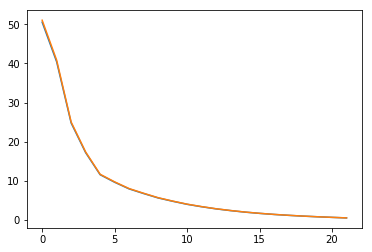

In [6]:
plt.plot(avg_irrad)
plt.plot(avg_irrad_mod)

In [7]:
rel_err = ((avg_irrad - avg_irrad_mod)/avg_irrad)

In [8]:
avg_irrad

array([ 50.53313044,  40.41120083,  24.76004386,  17.17944164,
        11.53884953,   9.61327729,   7.91174782,   6.72500026,
         5.60258913,   4.75070597,   3.96870763,   3.3501097 ,
         2.80357718,   2.35853921,   1.96899619,   1.65215683,
         1.37752099,   1.1496687 ,   0.94908489,   0.78075289,
         0.62931238,   0.49080476])

In [11]:
z, i1, i2  = kelp_analyze.merge_diff_grids(zmin, zmax, avg_irrad, avg_irrad_mod)

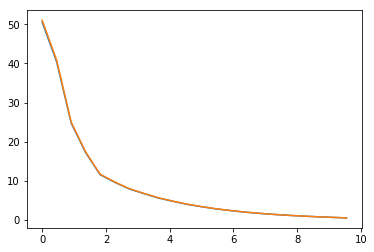

In [13]:
plt.plot(z[:-1], i1, label='i1 (orig)')
plt.plot(z[:-1], i2, label='i2 (mod)')

In [14]:
np.mean(np.abs((i2-i1)/i1))

0.0099999999999999048

In [19]:
abs_err, rel_err = kelp_analyze.discrete_err(zmin, zmax, avg_irrad, avg_irrad_mod)
print("rel_err = {}".format(rel_err))

rel_err = 0.009999999999999927


Woohoo! That looks great!

# Compare similar fields, resampled spatial grid

## Resample

In [20]:
from scipy.interpolate import griddata

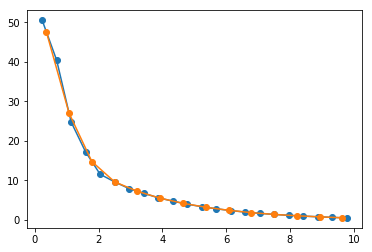

In [21]:
nz = 22
dz = (zmax - zmin) / nz
z = dz * (np.arange(nz) + 0.5)
nz_new = 14
dz_new = (zmax - zmin) / nz_new
z_new = dz_new * (np.arange(nz_new) + 0.5)
resampled_irrad = griddata(z, avg_irrad, z_new)
plt.plot(z, avg_irrad, 'o-')
plt.plot(z_new, resampled_irrad, 'o-')

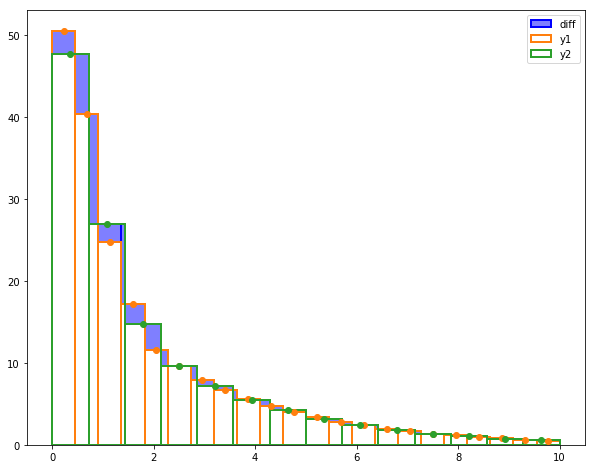

In [22]:
kelp_analyze.plot_discrete_diff(zmin, zmax, avg_irrad, resampled_irrad)

In [25]:
abs_err, rel_err = kelp_analyze.discrete_err(zmin, zmax, avg_irrad, resampled_irrad)
print("rel_err = {}".format(rel_err))

rel_err = 0.12624780731847568


# Linear interpolation

In [122]:
z_both, avg_irrad_both, resampled_irrad_both = merge_linear(z, z_new, avg_irrad, resampled_irrad)

rel_err = 0.025824562452005047


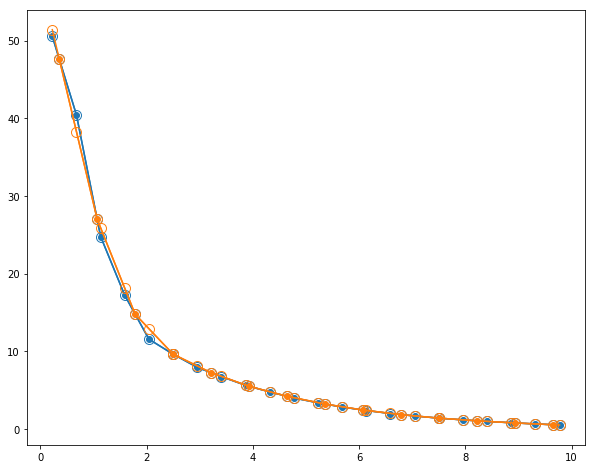

In [123]:
plt.figure(figsize=[10,8])
plt.plot(z_both, avg_irrad_both, 'C0o-', mfc=(0,0,0,0), mec='C0', ms=10)
plt.plot(z, avg_irrad, 'o-', mec='C0', mfc='C0')

plt.plot(z_both, resampled_irrad_both, 'C1o-', mfc=(0,0,0,0), mec='C1', ms=10)
plt.plot(z_new, resampled_irrad, 'o-', mec='C1', mfc='C1')

abs_err, rel_err = err_linear(z, z_new, avg_irrad, resampled_irrad)
print("rel_err = {}".format(rel_err))

# Results:

---

Piecewise constant, positive area: 

```rel_err = 0.12624780731847568```

Piecewise constant, diff. area:

```rel_err = 0.0041056012284212025```

---

The discrete difference itself introduces quite a bit of error,
so it seems that it would be better just to do the error
based on linear interpolation.

---

Linear interpolation, extrapolate, positive area:

```rel_err = 0.025824562452005047```

Linear interpolation, extrapolate, diff. area:

```rel_err = 0.0064762899759451525```

---

The linear interpolation also introduces some error, but less than the piecewise constant algorithm. I think it's best to go with linear interpolation, positive area, since it seems important to have positive area rather than net area.

Perhaps it's possible to account for the error incurred solely due to resampling and eliminate this value?

Either way, the linear 2% is not so bad compared to the 12% for piecewise constant .

# TODO:

- Try with identical grid, make sure linear interpolation shows 0% error when not modified, and correct 1% error when modified.
- Compare linear and piecewise interpolation with induced error.
